In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print(tf. __version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


In [2]:
import os
import cv2
import numpy as np

import shutil
import glob
#dir = os.cur_dirr()
for dirname, _, filenames in os.walk('./data', topdown=True):
    print(dirname)

./data
./data\Test
./data\Test\Airbus_A380
./data\Test\Boeing_B737
./data\Test\Boeing_B747
./data\Test\Boeing_B767
./data\Test\Bombardier_CRJ
./data\Train
./data\Train\Airbus_A380
./data\Train\Boeing_B737
./data\Train\Boeing_B747
./data\Train\Boeing_B767
./data\Train\Bombardier_CRJ
./data\Val
./data\Val\Airbus_A380
./data\Val\Boeing_B737
./data\Val\Boeing_B747
./data\Val\Boeing_B767
./data\Val\Bombardier_CRJ


<h3>Prerequisites<h3> 

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.applications.inception_v3 as inception_v3
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.applications.resnet50 as resnet50
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Flatten
from keras.applications import InceptionV3
from keras.models import load_model
from tensorflow.keras import utils
import tensorflow as tf

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
#from apps.dataset import Dataset
from PIL import Image
import numpy as np
import pandas as pd
import random
import json
import os



<h3>Data load and augumentation </h3>

In [4]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

img_gen_train = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(rescale=1./255,
                             preprocessing_function=preprocess_input)

In [5]:
train_dataset = img_gen_train.flow_from_directory('data/train',
                                                  target_size=(299,299),
                                                  shuffle = True)

val_dataset = img_gen.flow_from_directory('data/val',
                                          target_size=(299,299),
                                          shuffle = True)

test_dataset = img_gen.flow_from_directory('data/test',
                                           target_size=(299,299),
                                           shuffle = False)

Found 1706 images belonging to 5 classes.
Found 595 images belonging to 5 classes.
Found 1165 images belonging to 5 classes.


<h3>Model Creation</h3>

As base model InveptionV3 architecture (without top layer) is used. Top layer consists of one Flatten layer, Dense layer, Dropout and Dense layer.


In [6]:
model_base = InceptionV3(weights = 'imagenet', include_top=False, input_shape = (299, 299, 3))

for layer in model_base.layers:
    layer.trainable = True
    
n_classes = len(set(train_dataset.classes))

top_model = Sequential()
top_model.add(Flatten(input_shape = model_base.output_shape[1:]))
top_model.add(Dense(200, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_classes, activation='softmax'))

model = Sequential()
model.add(model_base)
model.add(top_model)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 5)                 26215605  
                                                                 
Total params: 48,018,389
Trainable params: 47,983,957
Non-trainable params: 34,432
_________________________________________________________________


In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, monitor="val_loss")

checkpoint_path = './checkpoint_full/' + 'model_base' + '-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
# Check if directory exists, create it if not
if not os.path.exists(os.path.dirname(checkpoint_path)):
    os.makedirs(os.path.dirname(checkpoint_path))
    
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)

tensorboard_callback = TensorBoard(log_dir='./logs')  # Define TensorBoard callback
with tf.device('/gpu:0'):
    history_base = History()
    model.fit(train_dataset, epochs=1000, batch_size=32, validation_data=val_dataset, callbacks=[early_stopping, checkpoint, history_base,tensorboard_callback])


Epoch 1/1000
54/54 [==============================] - ETA: 0s - loss: 1.8658 - accuracy: 0.4261
Epoch 1: val_loss improved from inf to 1.57533, saving model to ./checkpoint_full\model_base-ep001-loss1.866-val_loss1.575.h5
54/54 [==============================] - 155s 2s/step - loss: 1.8658 - accuracy: 0.4261 - val_loss: 1.5753 - val_accuracy: 0.4101
Epoch 2/1000
54/54 [==============================] - ETA: 0s - loss: 0.8082 - accuracy: 0.6776
Epoch 2: val_loss did not improve from 1.57533
54/54 [==============================] - 106s 2s/step - loss: 0.8082 - accuracy: 0.6776 - val_loss: 2.3464 - val_accuracy: 0.0017
Epoch 3/1000
54/54 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.8077
Epoch 3: val_loss did not improve from 1.57533
54/54 [==============================] - 105s 2s/step - loss: 0.5051 - accuracy: 0.8077 - val_loss: 1.6519 - val_accuracy: 0.1412
Epoch 4/1000
54/54 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.8880
Epoch 

In [8]:
model.save('final_models/model_001.h5')

In [9]:
import h5py

# Open the saved model file
with h5py.File('final_models/model_001.h5', 'r') as file:
    # Inspect the keys in the file
    print(list(file.keys()))


['model_weights', 'optimizer_weights']


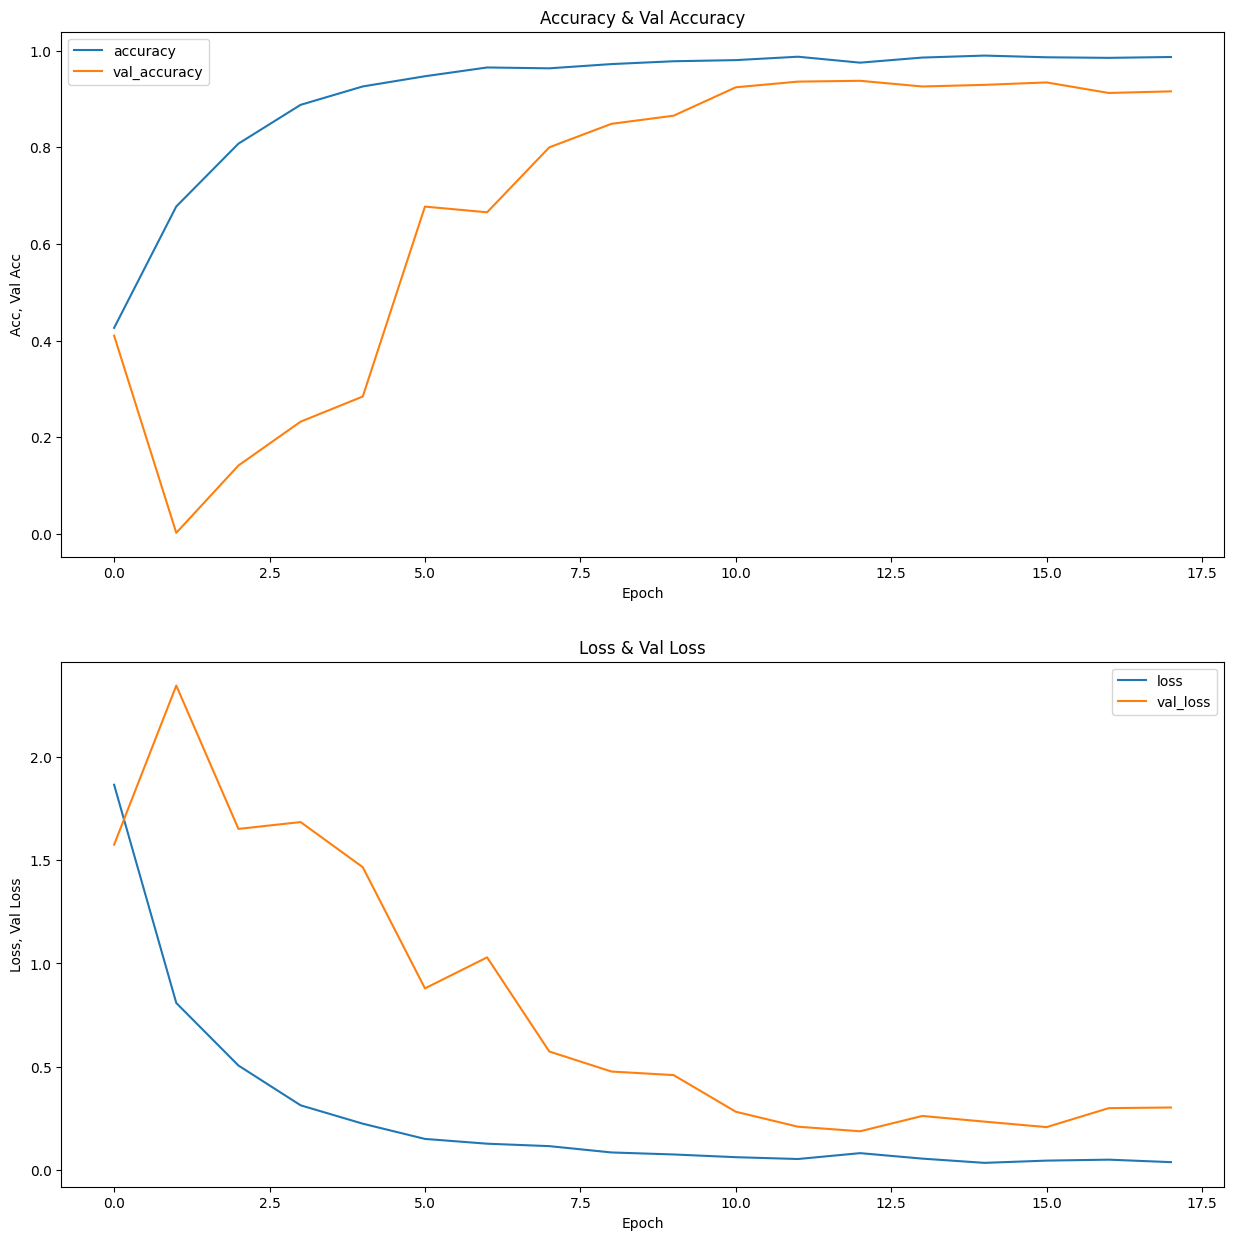

In [10]:
fig, axs = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
axs[0].plot(history_base.history['accuracy'], label = "accuracy")
axs[0].plot(history_base.history['val_accuracy'], label = "val_accuracy")
axs[0].legend()
axs[0].set_title('Accuracy & Val Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Acc, Val Acc')


axs[1].plot(history_base.history['loss'], label = "loss")
axs[1].plot(history_base.history['val_loss'], label = "val_loss")
axs[1].legend()
axs[1].set_title('Loss & Val Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss, Val Loss')


plt.show()

<h3>Post Processing</h3>

Load model after opening new jupyter session


In [1]:
from tensorflow.keras.models import load_model

# Load the model using the correct key
loaded_model = load_model('final_models/model_001.h5', custom_objects=None, compile=True, options=None)

# Now, you can use the loaded_model for evaluation or prediction
#model = load_model('final_models/model_001.h5')


In [13]:
evalu_1 = model.evaluate(test_dataset)

37/37 [==============================] - 19s 490ms/step - loss: 0.2046 - accuracy: 0.9485


<h3>Categorical Accuracy</h3>

In [14]:
preds = model.predict(test_dataset)
def get_key_by_value(d, value):
    for k, v in d.items():
        if v == value:
            return k
pd.set_option("display.max_rows", None, "display.max_columns", None)

preds_df_1 = pd.DataFrame({
    'File' : test_dataset.filenames,
    'Actual': [get_key_by_value(test_dataset.class_indices, line) for line in test_dataset.labels],
    'Prediction': [get_key_by_value(test_dataset.class_indices, np.argmax(line, axis=None, out=None)) for line in preds],
})

preds_df_1['Comparison Column'] = np.where(preds_df_1["Actual"] == preds_df_1["Prediction"], 1, 0)

names = {'Actual': 'Aircraft Variant',
        'Comparison Column' : 'Accuracy'}

categorical_accuracy_1 = preds_df_1.groupby('Actual')['Comparison Column'].mean()
categorical_accuracy_1 = categorical_accuracy_1.reset_index().rename(columns = names).set_index('Aircraft Variant').sort_values(by = 'Accuracy', ascending = False)
categorical_accuracy_1

37/37 [==============================] - 9s 227ms/step


Accuracy
Aircraft Variant          
Boeing_B737       0.990074
Bombardier_CRJ    0.979798
Airbus_A380       0.978541
Boeing_B767       0.896321
Boeing_B747       0.862595

In [15]:
acc_0p90 = len(categorical_accuracy_1[categorical_accuracy_1.Accuracy >= 0.90])
acc_0p75 = len(categorical_accuracy_1[categorical_accuracy_1.Accuracy >= 0.75])
acc_0p50 = len(categorical_accuracy_1[categorical_accuracy_1.Accuracy >= 0.50])
acc_0p25 = len(categorical_accuracy_1[categorical_accuracy_1.Accuracy >= 0.25])
acc_0p00 = len(categorical_accuracy_1[categorical_accuracy_1.Accuracy >= 0.00])

print(f'Accuracy is higher than 90% for {acc_0p90/acc_0p00 *100}% of categories')
print(f'Accuracy is higher than 75% for {acc_0p75/acc_0p00 *100}% of categories')
print(f'Accuracy is higher than 50% for {acc_0p50/acc_0p00 *100}% of categories')
print(f'Accuracy is higher than 25% for {acc_0p25/acc_0p00 *100}% of categories')

Accuracy is higher than 90% for 60.0% of categories
Accuracy is higher than 75% for 100.0% of categories
Accuracy is higher than 50% for 100.0% of categories
Accuracy is higher than 25% for 100.0% of categories


In [16]:
lowest_accuracy = categorical_accuracy_1[categorical_accuracy_1.Accuracy < 0.50]
lowest_accuracy

Empty DataFrame
Columns: [Accuracy]
Index: []

C:\Users\manja\AppData\Local\Temp\ipykernel_6548\2004816199.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


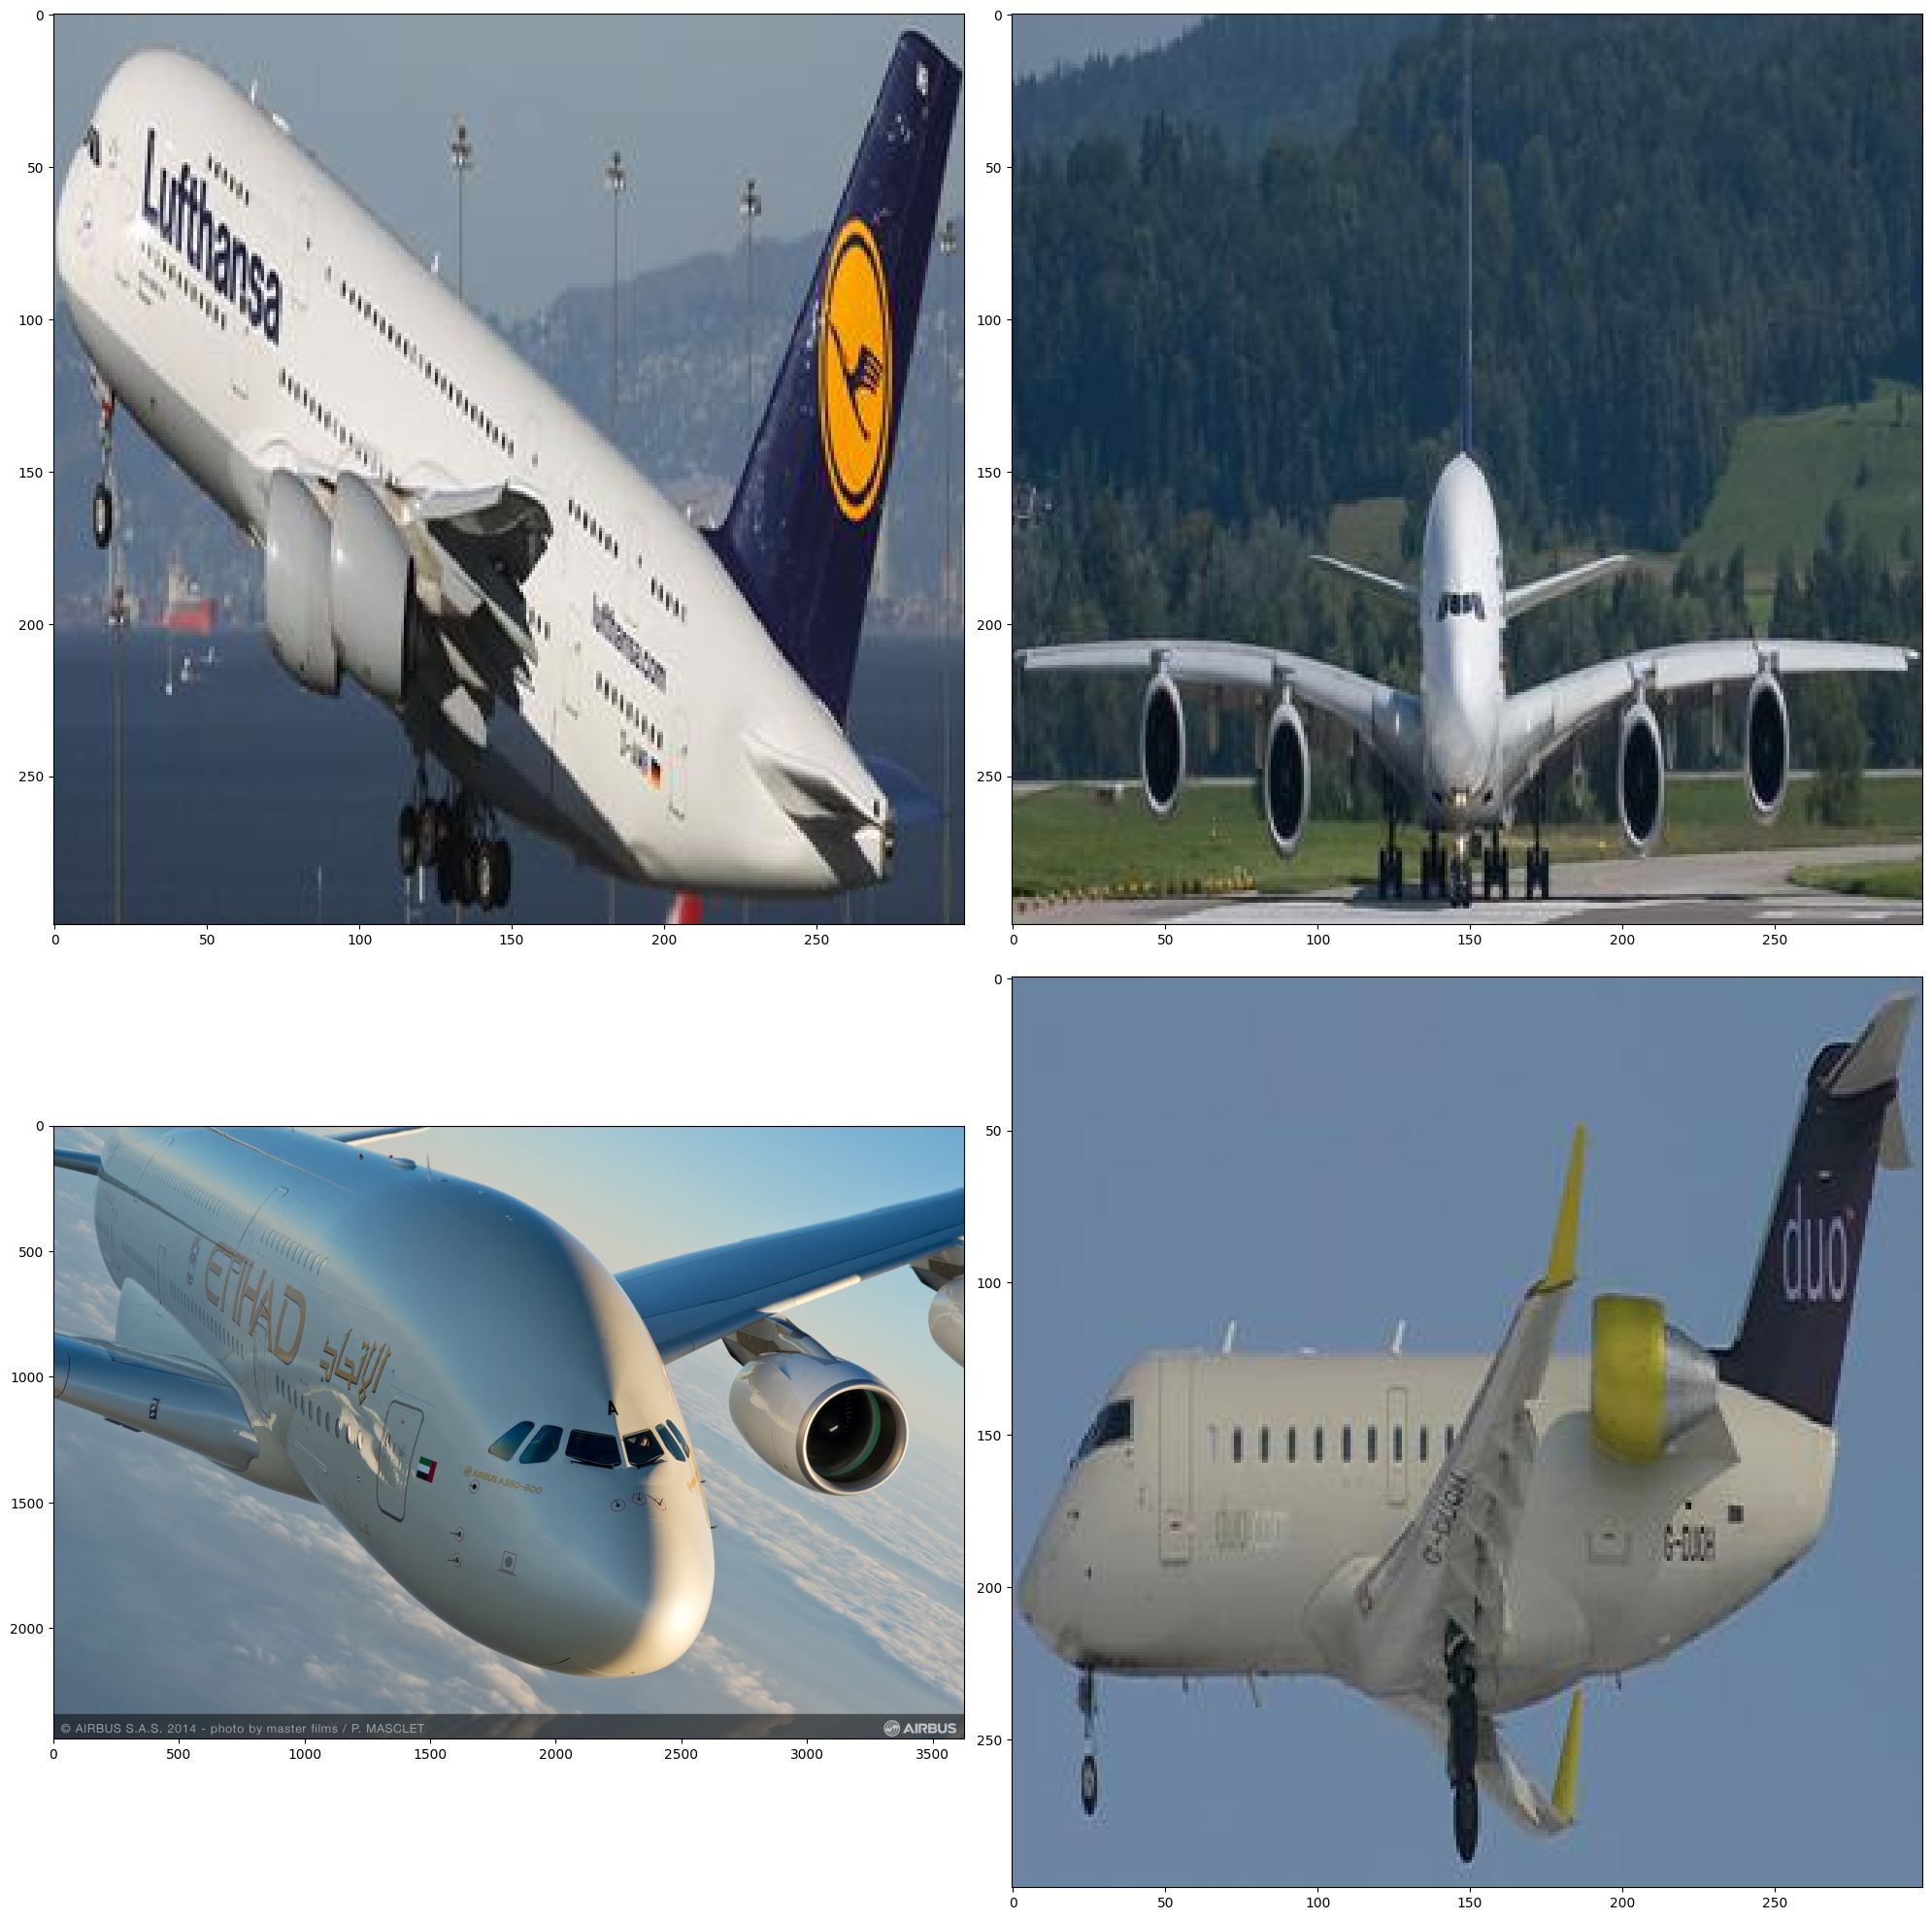

In [23]:
dir_images = ['Data/Test/Airbus_A380/2199048.jpg',
                 'Data/Test/Airbus_A380/Airbus-A380_ (5).jpeg',
                 'Data/Test/Airbus_A380/1811111.jpg',
                 'Data/Test/Bombardier_CRJ/0523111.jpg']

images = [Image.open(x) for x in dir_images]

f, axarr = plt.subplots(2,2, figsize=(20,20))
axarr[0,0].imshow(images[0])
axarr[1,0].imshow(images[1])
axarr[0,1].imshow(images[2])
axarr[1,1].imshow(images[3])
#axarr[0,1].imshow(images[4])
#axarr[1,1].imshow(images[5])
#axarr[2,1].imshow(images[6])
#axarr[3,1].imshow(images[7])

f.tight_layout()
f.show()

In [24]:
df_classification_report = pd.DataFrame(classification_report(preds_df_1['Actual'], preds_df_1['Prediction'], output_dict=True)).transpose()
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
df_classification_report

precision    recall  f1-score      support
Bombardier_CRJ   0.970000  0.979798  0.974874    99.000000
Airbus_A380      0.966102  0.978541  0.972281   233.000000
macro avg        0.963310  0.941466  0.950529  1165.000000
accuracy         0.948498  0.948498  0.948498     0.948498
weighted avg     0.952025  0.948498  0.948319  1165.000000
Boeing_B767      0.992593  0.896321  0.942004   299.000000
Boeing_B737      0.896629  0.990074  0.941038   403.000000
Boeing_B747      0.991228  0.862595  0.922449   131.000000

##################################################
File: Boeing_B737\1043473.jpg
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 3.913553570100703e-08
Class: Boeing_B737, Confidence Score: 0.9995550513267517
Class: Boeing_B747, Confidence Score: 2.4724715785851004e-06
Class: Boeing_B767, Confidence Score: 0.0004396190633997321
Class: Bombardier_CRJ, Confidence Score: 2.9086029371683253e-06
Prediction: Boeing_B737


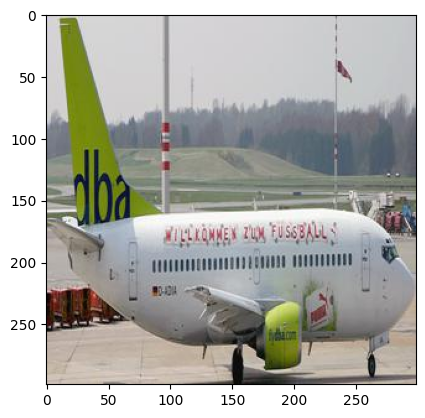

##################################################
File: Boeing_B767\Boeing-B767_ (65).png
Actual: Boeing_B767
Class: Airbus_A380, Confidence Score: 1.3846952029439308e-08
Class: Boeing_B737, Confidence Score: 1.003084776129981e-06
Class: Boeing_B747, Confidence Score: 1.6023631310702058e-09
Class: Boeing_B767, Confidence Score: 0.999998927116394
Class: Bombardier_CRJ, Confidence Score: 4.322671287582125e-08
Prediction: Boeing_B767


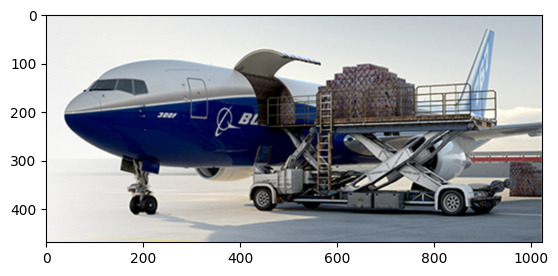

##################################################
File: Boeing_B737\0482804.jpg
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 6.145549564032238e-13
Class: Boeing_B737, Confidence Score: 0.9999979734420776
Class: Boeing_B747, Confidence Score: 2.5685798973884566e-12
Class: Boeing_B767, Confidence Score: 2.0498907815635903e-06
Class: Bombardier_CRJ, Confidence Score: 8.550978675136989e-11
Prediction: Boeing_B737


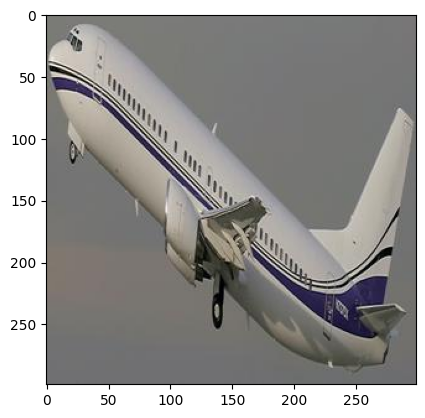

##################################################
File: Boeing_B737\Boeing-B737_ (72).png
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 2.086453189040216e-12
Class: Boeing_B737, Confidence Score: 0.9999998807907104
Class: Boeing_B747, Confidence Score: 2.1172616611331296e-12
Class: Boeing_B767, Confidence Score: 6.813480268874628e-08
Class: Bombardier_CRJ, Confidence Score: 1.0705922910345111e-12
Prediction: Boeing_B737


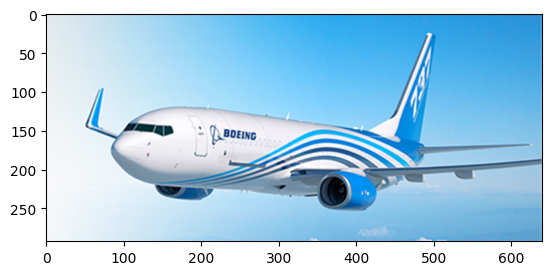

##################################################
File: Boeing_B737\0147057.jpg
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 3.609767063039726e-08
Class: Boeing_B737, Confidence Score: 0.9998186230659485
Class: Boeing_B747, Confidence Score: 1.567897669474405e-07
Class: Boeing_B767, Confidence Score: 0.00018122943583875895
Class: Bombardier_CRJ, Confidence Score: 4.0850068216968793e-08
Prediction: Boeing_B737


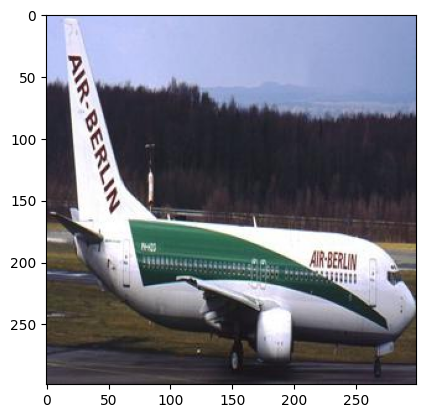

##################################################
File: Boeing_B747\0127505.jpg
Actual: Boeing_B747
Class: Airbus_A380, Confidence Score: 0.0002539726556278765
Class: Boeing_B737, Confidence Score: 8.279277244582772e-05
Class: Boeing_B747, Confidence Score: 0.9996521472930908
Class: Boeing_B767, Confidence Score: 8.75673140399158e-06
Class: Bombardier_CRJ, Confidence Score: 2.3825120933906874e-06
Prediction: Boeing_B747


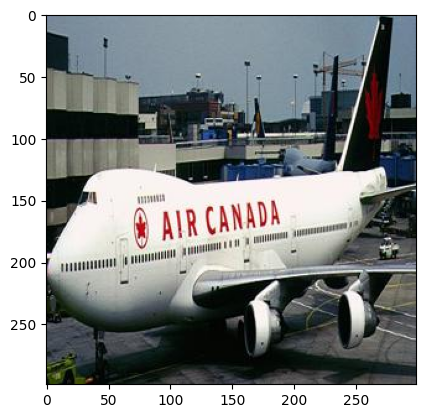

##################################################
File: Boeing_B747\1572354.jpg
Actual: Boeing_B747
Class: Airbus_A380, Confidence Score: 0.0007883124053478241
Class: Boeing_B737, Confidence Score: 0.986393392086029
Class: Boeing_B747, Confidence Score: 0.011319689452648163
Class: Boeing_B767, Confidence Score: 0.00143349205609411
Class: Bombardier_CRJ, Confidence Score: 6.518916052300483e-05
Prediction: Boeing_B737


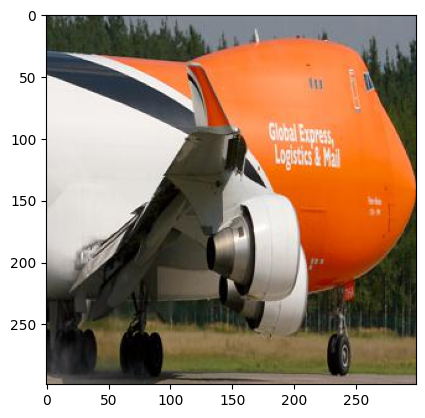

##################################################
File: Boeing_B767\Boeing-B767_ (284).jpeg
Actual: Boeing_B767
Class: Airbus_A380, Confidence Score: 1.7449758161092177e-05
Class: Boeing_B737, Confidence Score: 0.02500000223517418
Class: Boeing_B747, Confidence Score: 4.170888860244304e-05
Class: Boeing_B767, Confidence Score: 0.9747529625892639
Class: Bombardier_CRJ, Confidence Score: 0.00018791397451423109
Prediction: Boeing_B767


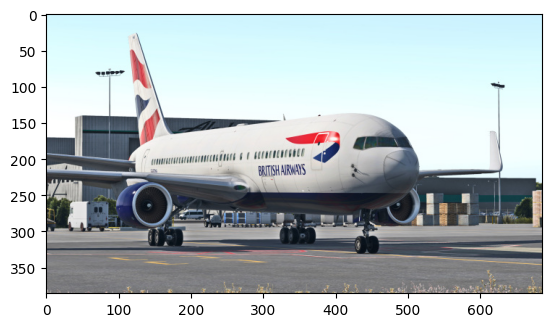

##################################################
File: Boeing_B737\Boeing-B737_ (54).png
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 2.086453189040216e-12
Class: Boeing_B737, Confidence Score: 0.9999998807907104
Class: Boeing_B747, Confidence Score: 2.1172616611331296e-12
Class: Boeing_B767, Confidence Score: 6.813480268874628e-08
Class: Bombardier_CRJ, Confidence Score: 1.0705922910345111e-12
Prediction: Boeing_B737


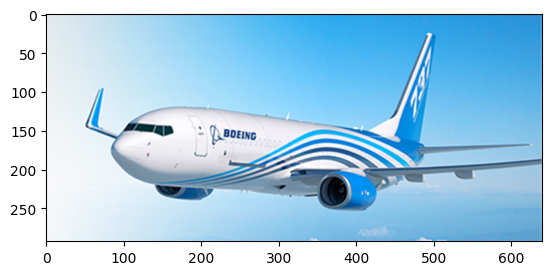

##################################################
File: Boeing_B737\1354835.jpg
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 1.35198696682437e-08
Class: Boeing_B737, Confidence Score: 0.999995231628418
Class: Boeing_B747, Confidence Score: 4.3391349180410543e-08
Class: Boeing_B767, Confidence Score: 4.707176685769809e-06
Class: Bombardier_CRJ, Confidence Score: 2.969564594224039e-09
Prediction: Boeing_B737


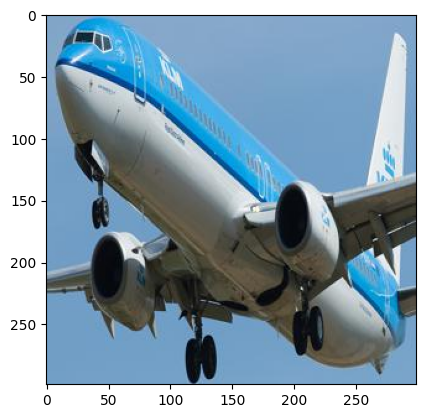

##################################################
File: Boeing_B747\1626629.jpg
Actual: Boeing_B747
Class: Airbus_A380, Confidence Score: 7.861978519940749e-05
Class: Boeing_B737, Confidence Score: 9.167107464236324e-07
Class: Boeing_B747, Confidence Score: 0.9999203681945801
Class: Boeing_B767, Confidence Score: 8.389044836576431e-08
Class: Bombardier_CRJ, Confidence Score: 6.201650748494103e-09
Prediction: Boeing_B747


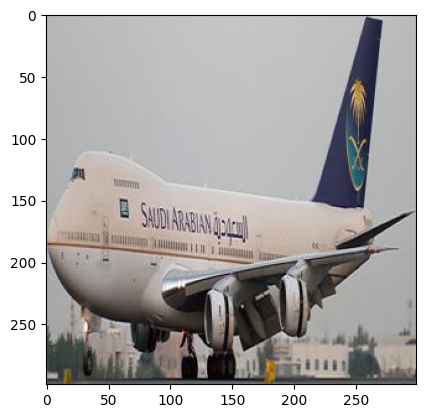

##################################################
File: Boeing_B737\1238449.jpg
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 0.0015631351852789521
Class: Boeing_B737, Confidence Score: 0.5725814700126648
Class: Boeing_B747, Confidence Score: 0.20657271146774292
Class: Boeing_B767, Confidence Score: 0.2023954689502716
Class: Bombardier_CRJ, Confidence Score: 0.01688721776008606
Prediction: Boeing_B737


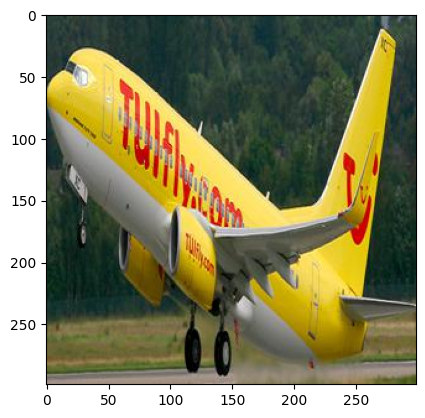

##################################################
File: Airbus_A380\Airbus-A380_ (95).png
Actual: Airbus_A380
Class: Airbus_A380, Confidence Score: 1.0
Class: Boeing_B737, Confidence Score: 8.040581395141189e-11
Class: Boeing_B747, Confidence Score: 8.073190727042601e-11
Class: Boeing_B767, Confidence Score: 6.084512893522742e-10
Class: Bombardier_CRJ, Confidence Score: 3.3160045889712997e-12
Prediction: Airbus_A380


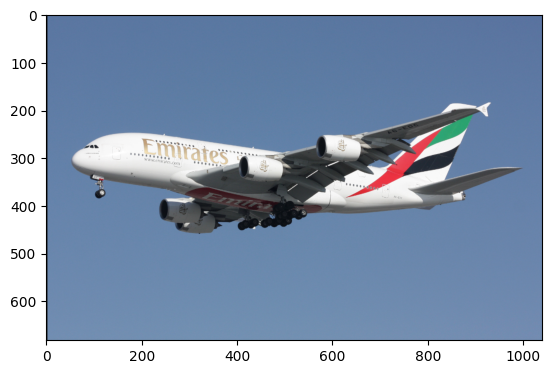

##################################################
File: Bombardier_CRJ\1221335.jpg
Actual: Bombardier_CRJ
Class: Airbus_A380, Confidence Score: 6.160732937132707e-06
Class: Boeing_B737, Confidence Score: 4.325047484599054e-05
Class: Boeing_B747, Confidence Score: 5.190626097828499e-07
Class: Boeing_B767, Confidence Score: 8.006308053154498e-05
Class: Bombardier_CRJ, Confidence Score: 0.9998699426651001
Prediction: Bombardier_CRJ


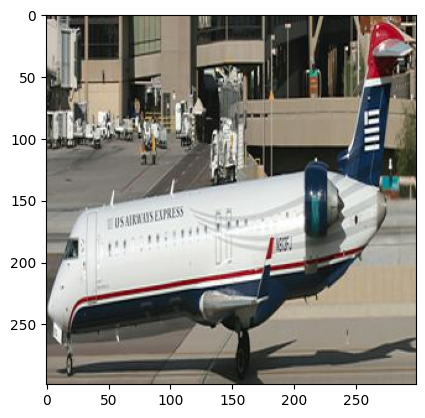

##################################################
File: Boeing_B737\1696061.jpg
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 5.647608438850635e-14
Class: Boeing_B737, Confidence Score: 1.0
Class: Boeing_B747, Confidence Score: 1.0962708334432553e-13
Class: Boeing_B767, Confidence Score: 3.45070496621247e-08
Class: Bombardier_CRJ, Confidence Score: 1.6004579606043734e-10
Prediction: Boeing_B737


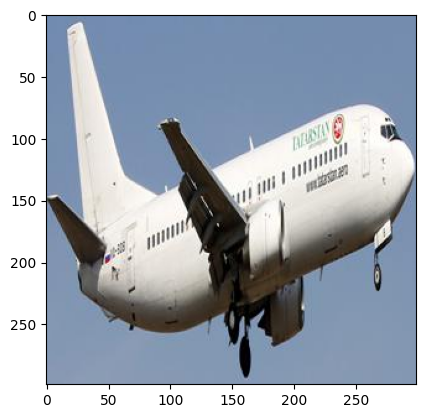

##################################################
File: Airbus_A380\Airbus-A380_ (83).png
Actual: Airbus_A380
Class: Airbus_A380, Confidence Score: 1.0
Class: Boeing_B737, Confidence Score: 8.040581395141189e-11
Class: Boeing_B747, Confidence Score: 8.073190727042601e-11
Class: Boeing_B767, Confidence Score: 6.084512893522742e-10
Class: Bombardier_CRJ, Confidence Score: 3.3160045889712997e-12
Prediction: Airbus_A380


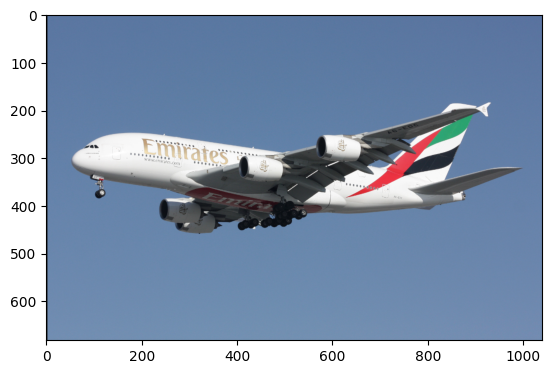

##################################################
File: Boeing_B767\0783932.jpg
Actual: Boeing_B767
Class: Airbus_A380, Confidence Score: 2.9160610037770596e-10
Class: Boeing_B737, Confidence Score: 0.00041310672531835735
Class: Boeing_B747, Confidence Score: 7.3647279386079845e-09
Class: Boeing_B767, Confidence Score: 0.9995868802070618
Class: Bombardier_CRJ, Confidence Score: 2.0701824254842904e-08
Prediction: Boeing_B767


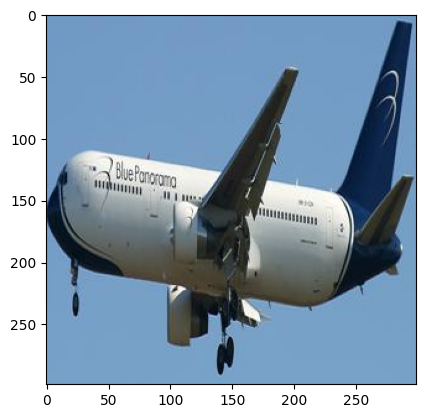

##################################################
File: Boeing_B737\1455998.jpg
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 3.4852553199016256e-06
Class: Boeing_B737, Confidence Score: 0.9996678829193115
Class: Boeing_B747, Confidence Score: 6.20861173956655e-05
Class: Boeing_B767, Confidence Score: 0.00023974631039891392
Class: Bombardier_CRJ, Confidence Score: 2.6834864911506884e-05
Prediction: Boeing_B737


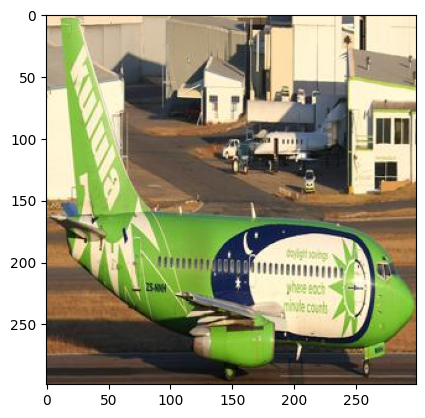

##################################################
File: Boeing_B737\1946040.jpg
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 0.0005938016693107784
Class: Boeing_B737, Confidence Score: 0.9283520579338074
Class: Boeing_B747, Confidence Score: 0.0013637655647471547
Class: Boeing_B767, Confidence Score: 0.060493454337120056
Class: Bombardier_CRJ, Confidence Score: 0.009196875616908073
Prediction: Boeing_B737


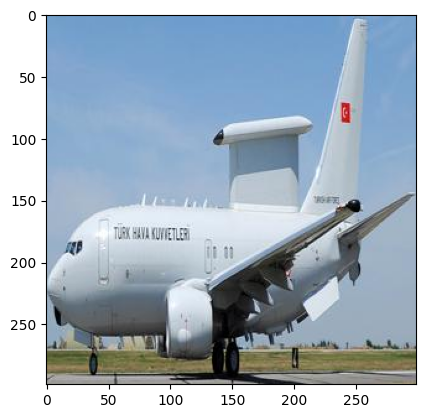

##################################################
File: Boeing_B737\1876022.jpg
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 0.004964574705809355
Class: Boeing_B737, Confidence Score: 0.9908679723739624
Class: Boeing_B747, Confidence Score: 0.0012008307967334986
Class: Boeing_B767, Confidence Score: 0.00040603926754556596
Class: Bombardier_CRJ, Confidence Score: 0.00256045232526958
Prediction: Boeing_B737


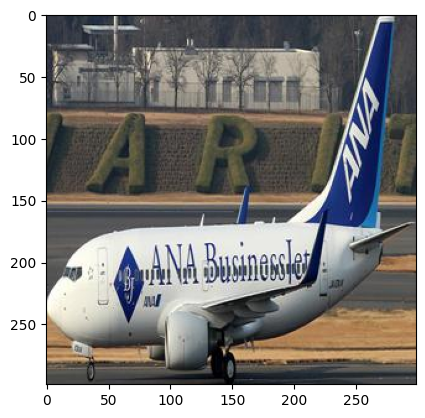

##################################################
File: Boeing_B767\Boeing-B767_ (50).png
Actual: Boeing_B767
Class: Airbus_A380, Confidence Score: 1.3846952029439308e-08
Class: Boeing_B737, Confidence Score: 1.003084776129981e-06
Class: Boeing_B747, Confidence Score: 1.6023631310702058e-09
Class: Boeing_B767, Confidence Score: 0.999998927116394
Class: Bombardier_CRJ, Confidence Score: 4.322671287582125e-08
Prediction: Boeing_B767


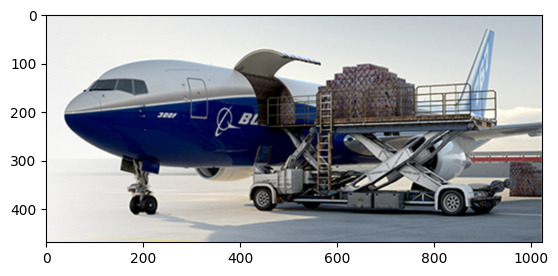

##################################################
File: Boeing_B767\Boeing-B767_ (91).png
Actual: Boeing_B767
Class: Airbus_A380, Confidence Score: 4.709028278426786e-09
Class: Boeing_B737, Confidence Score: 8.35057903714187e-07
Class: Boeing_B747, Confidence Score: 3.3684569022973676e-11
Class: Boeing_B767, Confidence Score: 0.9999980926513672
Class: Bombardier_CRJ, Confidence Score: 1.0170764426220558e-06
Prediction: Boeing_B767


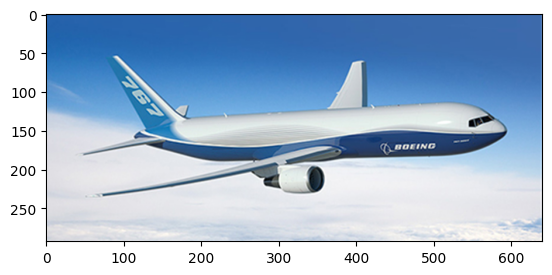

##################################################
File: Boeing_B747\0989831.jpg
Actual: Boeing_B747
Class: Airbus_A380, Confidence Score: 1.0622510444591171e-06
Class: Boeing_B737, Confidence Score: 2.9845416065654717e-05
Class: Boeing_B747, Confidence Score: 0.9999685287475586
Class: Boeing_B767, Confidence Score: 6.308177376013191e-07
Class: Bombardier_CRJ, Confidence Score: 1.1839816238534695e-08
Prediction: Boeing_B747


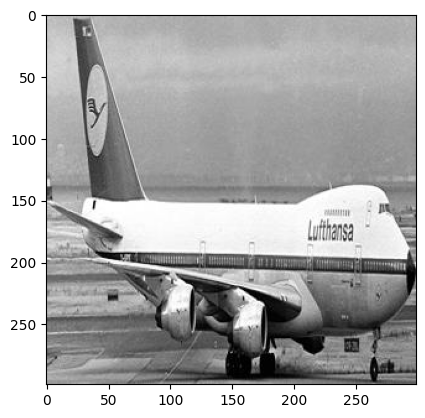

##################################################
File: Boeing_B737\0635825.jpg
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 2.182036773490381e-09
Class: Boeing_B737, Confidence Score: 0.9998525381088257
Class: Boeing_B747, Confidence Score: 4.730642544359398e-08
Class: Boeing_B767, Confidence Score: 0.0001474044838687405
Class: Bombardier_CRJ, Confidence Score: 4.401671205300772e-08
Prediction: Boeing_B737


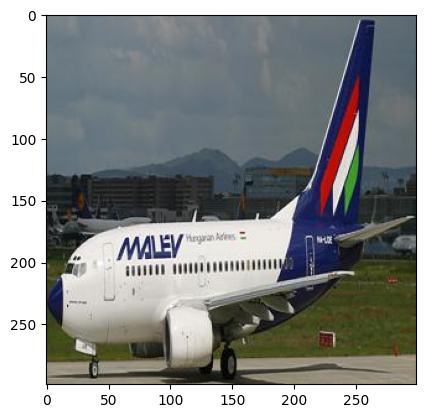

##################################################
File: Airbus_A380\Airbus-A380_ (4).jpeg
Actual: Airbus_A380
Class: Airbus_A380, Confidence Score: 0.9999849796295166
Class: Boeing_B737, Confidence Score: 5.379117169468373e-07
Class: Boeing_B747, Confidence Score: 1.2717247955151834e-05
Class: Boeing_B767, Confidence Score: 1.67505390891165e-06
Class: Bombardier_CRJ, Confidence Score: 3.250591262826674e-08
Prediction: Airbus_A380


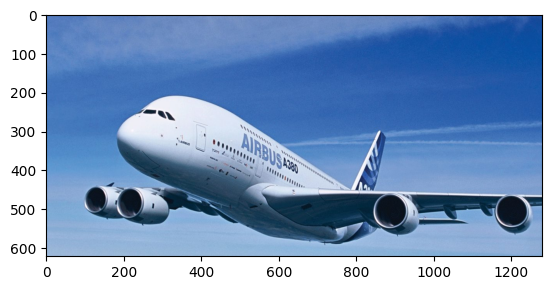

##################################################
File: Airbus_A380\Airbus-A380_ (45).jpeg
Actual: Airbus_A380
Class: Airbus_A380, Confidence Score: 1.0
Class: Boeing_B737, Confidence Score: 7.694014314552078e-09
Class: Boeing_B747, Confidence Score: 8.162585274362755e-09
Class: Boeing_B767, Confidence Score: 1.977996211266486e-09
Class: Bombardier_CRJ, Confidence Score: 1.3085443319182932e-11
Prediction: Airbus_A380


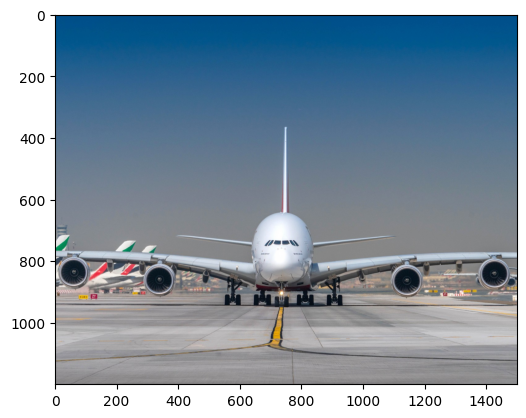

##################################################
File: Boeing_B737\0635825.jpg
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 2.182036773490381e-09
Class: Boeing_B737, Confidence Score: 0.9998525381088257
Class: Boeing_B747, Confidence Score: 4.730642544359398e-08
Class: Boeing_B767, Confidence Score: 0.0001474044838687405
Class: Bombardier_CRJ, Confidence Score: 4.401671205300772e-08
Prediction: Boeing_B737


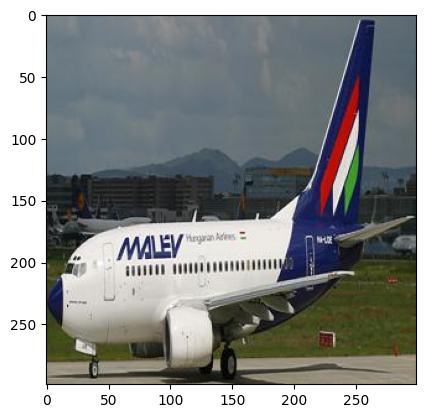

##################################################
File: Boeing_B767\Boeing-B767_ (281).jpeg
Actual: Boeing_B767
Class: Airbus_A380, Confidence Score: 1.0948870254878784e-07
Class: Boeing_B737, Confidence Score: 2.987427251355257e-05
Class: Boeing_B747, Confidence Score: 1.0367501523944611e-08
Class: Boeing_B767, Confidence Score: 0.9999698400497437
Class: Bombardier_CRJ, Confidence Score: 1.4398965220152604e-07
Prediction: Boeing_B767


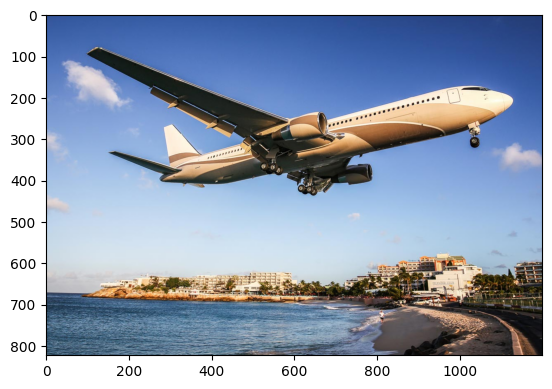

##################################################
File: Airbus_A380\Airbus-A380_ (62).png
Actual: Airbus_A380
Class: Airbus_A380, Confidence Score: 1.0
Class: Boeing_B737, Confidence Score: 4.473060588594535e-09
Class: Boeing_B747, Confidence Score: 3.110004698214652e-08
Class: Boeing_B767, Confidence Score: 6.751601500099014e-09
Class: Bombardier_CRJ, Confidence Score: 3.558699335215465e-09
Prediction: Airbus_A380


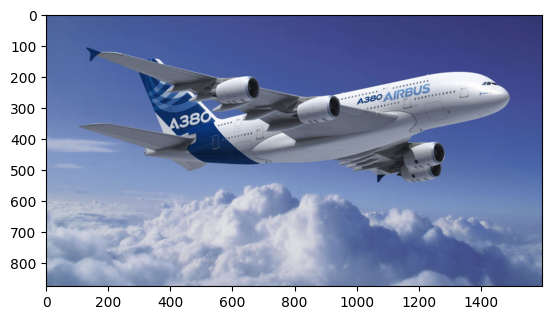

##################################################
File: Boeing_B737\1129244.jpg
Actual: Boeing_B737
Class: Airbus_A380, Confidence Score: 4.200386834006661e-15
Class: Boeing_B737, Confidence Score: 0.9999997615814209
Class: Boeing_B747, Confidence Score: 1.2826507434296475e-13
Class: Boeing_B767, Confidence Score: 1.957772468585972e-07
Class: Bombardier_CRJ, Confidence Score: 1.1382050629695634e-13
Prediction: Boeing_B737


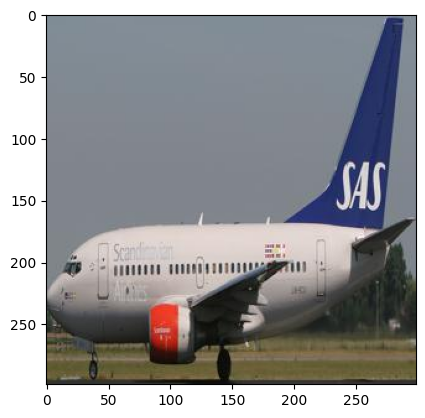

In [40]:
number_of_test_images = len(test_dataset.filenames)
random_numbers = [random.randint(0,number_of_test_images-1) for x in range(0,30)]
classes = ["Airbus_A380","Boeing_B737","Boeing_B747","Boeing_B767","Bombardier_CRJ"]
for index in random_numbers:
    print('#'*50)
    file = preds_df_1.iloc[index]['File']
    print('File:',file)
    print('Actual:',preds_df_1.iloc[index]['Actual'])
    # Assuming preds is the output of model.predict()
    confidence_scores = preds[index]

    # Print confidence scores for each class
    for i, score in enumerate(confidence_scores):
        print(f'Class: {classes[i]}, Confidence Score: {score}')
    print('Prediction:',preds_df_1.iloc[index]['Prediction'])
    img = Image.open('Data/test/'+file)
    plt.imshow(img)
    plt.show()

File: .\Video_input_and_output\dornier_328.jpg
Actual: Dornier_328
Class: Airbus_A380, Confidence Score: 1.3846952029439308e-08
Class: Boeing_B737, Confidence Score: 1.003084776129981e-06
Class: Boeing_B747, Confidence Score: 1.6023631310702058e-09
Class: Boeing_B767, Confidence Score: 0.999998927116394
Class: Bombardier_CRJ, Confidence Score: 4.322671287582125e-08
Prediction: Boeing_B767


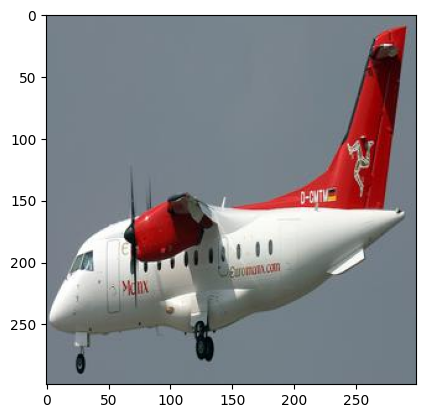

In [38]:
file = ".\Video_input_and_output\dornier_328.jpg"
print('File:', file)
#print('Actual:', preds_df_1.iloc[index]['Actual'])
print('Actual: Dornier_328')

# Assuming preds is the output of model.predict()
confidence_scores = preds[index]

# Print confidence scores for each class
for i, score in enumerate(confidence_scores):
    print(f'Class: {classes[i]}, Confidence Score: {score}')

print('Prediction:', preds_df_1.iloc[index]['Prediction'])

img = Image.open(file)
plt.imshow(img)
plt.show()


<h2> Apply the Video classification </h2>

import cv2
import numpy as np

classes = ["Airbus_A380","Boeing_B737","Boeing_B747","Boeing_B767","Bombardier_CRJ"]

def predict_and_highlight_flight(video_path, model):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    width = int(cap.get(3))
    height = int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('Video_input_and_output/Output/fish1.mp4', fourcc, fps, (width, height))
    
    # Loop through each frame in the video
    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Preprocess the frame
        resized_frame = cv2.resize(frame, (299, 299))
        normalized_frame = resized_frame / 255.0  # Normalize pixel values
        
        # Expand dimensions to match model input shape
        input_frame = np.expand_dims(normalized_frame, axis=0)
        
        # Make predictions using the model
        predictions = model.predict(input_frame)
        
        # Get the predicted class index
        predicted_class_index = np.argmax(predictions)
        
        # Check if the predicted class corresponds to any flight class
        if predicted_class_index in range(len(classes)):
            # Draw bounding box in green
            color = (0, 255, 0)
        else:
            # Draw bounding box in red
            color = (0, 0, 255)
        
        # Highlight or draw bounding box
        cv2.rectangle(frame, (0, 0), (width, height), color, 2)
        
        # Get the predicted class label
        predicted_class_label = classes[predicted_class_index] if predicted_class_index in range(len(classes)) else 'Unknown'
        
        # Display the predicted class label
        cv2.putText(frame, f"Class: {predicted_class_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Write the frame to the output video
        out.write(frame)
        
        # Calculate time in seconds
        time_in_seconds = frame_index / fps
        
        # Display the time in seconds
        print(f"Time: {time_in_seconds:.2f} seconds, Predicted Class: {predicted_class_label}")
        
        # Increment the frame index
        frame_index += 1
        
        # Display the frame
        cv2.imshow('Video', frame)
        
        # Break the loop if 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release video capture and writer objects
    cap.release()
    out.release()
    
    # Close all OpenCV windows
    cv2.destroyAllWindows()

# Call the prediction function with the video path and trained model
predict_and_highlight_flight('./Video_input_and_output/Input/fish1.mp4', model)

import cv2
import numpy as np

classes = ["Airbus_A380", "Boeing_B737", "Boeing_B747", "Boeing_B767", "Bombardier_CRJ"]

def predict_and_highlight_flight(video_path, model, actual_labels):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    width = int(cap.get(3))
    height = int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Define total_frames
    
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('Video_input_and_output/Output/fish1.mp4', fourcc, fps, (width, height))
    
    # Loop through each frame in the video
    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Preprocess the frame
        resized_frame = cv2.resize(frame, (299, 299))
        normalized_frame = resized_frame / 255.0  # Normalize pixel values
        
        # Expand dimensions to match model input shape
        input_frame = np.expand_dims(normalized_frame, axis=0)
        
        # Make predictions using the model
        predictions = model.predict(input_frame)
        
        # Get the predicted class index
        predicted_class_index = np.argmax(predictions)

        # Get the predicted class label
        predicted_class_label = classes[predicted_class_index] if predicted_class_index in range(len(classes)) else 'Unknown'
        
        # # Check if the predicted class corresponds to any flight class
        # if predicted_class_index in range(len(classes)):
        #     # Draw bounding box in green
        #     color = (0, 255, 0)
        # else:
        #     # Draw bounding box in red
        #     color = (0, 0, 255)

        

        
         # Get the actual class label
        #actual_label = actual_labels[frame_index]
        actual_label = actual_labels
        
        # Check if actual and predicted labels match
        if actual_label == predicted_class_label:
            # Display predicted, actual, and confidence score in the left corner
            text = f"Predicted: {predicted_class_label}\nActual: {actual_label}\nConfidence: {np.max(predictions):.2f}"
        else:
            # If actual and predicted labels don't match, mark the box as red
            color = (0, 0, 255)
            # Display predicted, actual, and confidence score in the left corner
            text = f"Predicted: {predicted_class_label}\nActual: {actual_label}\nConfidence: {np.max(predictions):.2f}"
        



        
        # Highlight or draw bounding box
        cv2.rectangle(frame, (0, 0), (width, height), color, 2)
        
        # # Display the predicted class label
        cv2.putText(frame, f"Class: {predicted_class_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # # Display the actual class label
        cv2.putText(frame, f"Actual: {actual_class}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # # Display the confidence score
        confidence_score = predictions[0][predicted_class_index]
        cv2.putText(frame, f"Confidence: {confidence_score:.2f}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        
        
        # Write the frame to the output video
        out.write(frame)
        
        # Calculate time in seconds
        time_in_seconds = frame_index / fps
        
        # Display the time in seconds
        print(f"Time: {time_in_seconds:.2f} seconds, Predicted Class: {predicted_class_label}, Actual Class: {actual_class}")
        
        # Increment the frame index
        frame_index += 1
        
        # Display the frame
        cv2.imshow('Video', frame)
        
        # Break the loop if 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release video capture and writer objects
    cap.release()
    out.release()
    
    # Close all OpenCV windows
    cv2.destroyAllWindows()

# Call the prediction function with the video path, trained model, and actual class
actual_class='Fish'
file ='./Video_input_and_output/Input/fish1.mp4'
predict_and_highlight_flight(file, model, actual_class)


In [17]:
import cv2
import numpy as np

classes = ["Airbus_A380", "Boeing_B737", "Boeing_B747", "Boeing_B767", "Bombardier_CRJ"]

def predict_and_highlight_flight(video_path, model, actual_labels):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    width = int(cap.get(3))
    height = int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Define total_frames
    
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('Video_input_and_output/Output/Boeing_B747_1.mp4', fourcc, fps, (width, height))
    
    # Loop through each frame in the video
    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Preprocess the frame
        resized_frame = cv2.resize(frame, (299, 299))
        normalized_frame = resized_frame / 255.0  # Normalize pixel values
        
        # Expand dimensions to match model input shape
        input_frame = np.expand_dims(normalized_frame, axis=0)
        
        # Make predictions using the model
        predictions = model.predict(input_frame)
        
        # Get the predicted class index
        predicted_class_index = np.argmax(predictions)

        # Get the predicted class label
        predicted_class_label = classes[predicted_class_index] if predicted_class_index in range(len(classes)) else 'Unknown'
        
        # Get the actual class label
        actual_label = actual_labels

        
        
        # Check if actual and predicted labels match
        if actual_label == predicted_class_label:
            color = (0, 255, 0)  # Default to green
            # Display predicted, actual, and confidence score in the left corner
            cv2.putText(frame, f"Predicted: {predicted_class_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(frame, f"Actual: {actual_label}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(frame, f"Confidence: {np.max(predictions):.2f}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            # Draw bounding box around the detected object (assuming object detection)
            # Adjust the coordinates and size based on your model's output
            box_coordinates = (100, 100, 200, 200)  # (x, y, width, height)
            cv2.rectangle(frame, (box_coordinates[0], box_coordinates[1]),
                          (box_coordinates[0] + box_coordinates[2], box_coordinates[1] + box_coordinates[3]),
                          (0, 255, 0), 2)  # Green bounding box
        else:
            # If actual and predicted labels don't match, mark the box as red
            color = (0, 0, 255)
            # Display predicted, actual, and confidence score in the left corner
            cv2.putText(frame, f"Predicted: {predicted_class_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(frame, f"Actual: {actual_label}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(frame, f"Confidence: {np.max(predictions):.2f}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            # Highlight or draw bounding box
            cv2.rectangle(frame, (0, 0), (width, height), color, 2)
        
        # Write the frame to the output video
        out.write(frame)
        
        # Calculate time in seconds
        time_in_seconds = frame_index / fps
        
        # Display the time in seconds
        print(f"Time: {time_in_seconds:.2f} seconds, Predicted Class: {predicted_class_label}, Actual Class: {actual_label}")
        
        # Increment the frame index
        frame_index += 1
        
        # Display the frame
        cv2.imshow('Video', frame)
        
        # Break the loop if 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release video capture and writer objects
    cap.release()
    out.release()
    
    # Close all OpenCV windows
    cv2.destroyAllWindows()

# Call the prediction function with the video path, trained model, and actual class
model = loaded_model
actual_class = 'Boeing_B747'
file = './Video_input_and_output/Input/Boeing_B747_1.mp4'
predict_and_highlight_flight(file, model, actual_class)


1/1 [==============================] - 0s 27ms/step
Time: 0.00 seconds, Predicted Class: Airbus_A380, Actual Class: Boeing_B747
1/1 [==============================] - 0s 25ms/step
Time: 0.03 seconds, Predicted Class: Airbus_A380, Actual Class: Boeing_B747
1/1 [==============================] - 0s 28ms/step
Time: 0.07 seconds, Predicted Class: Airbus_A380, Actual Class: Boeing_B747
1/1 [==============================] - 0s 28ms/step
Time: 0.10 seconds, Predicted Class: Airbus_A380, Actual Class: Boeing_B747
1/1 [==============================] - 0s 28ms/step
Time: 0.13 seconds, Predicted Class: Airbus_A380, Actual Class: Boeing_B747
1/1 [==============================] - 0s 24ms/step
Time: 0.17 seconds, Predicted Class: Airbus_A380, Actual Class: Boeing_B747
1/1 [==============================] - 0s 29ms/step
Time: 0.20 seconds, Predicted Class: Airbus_A380, Actual Class: Boeing_B747
1/1 [==============================] - 0s 29ms/step
Time: 0.23 seconds, Predicted Class: Airbus_A380, Ac